Loading datasets...
Training XGBoost model...
PR-AUC (TRAIN): 0.9613
Threshold: 0.574525
TRAIN -> Precision 0.900, Recall 0.900, F1 0.900, Pos 4326
TEST  -> Precision 0.750, Recall 0.018, F1 0.035, Pos 4


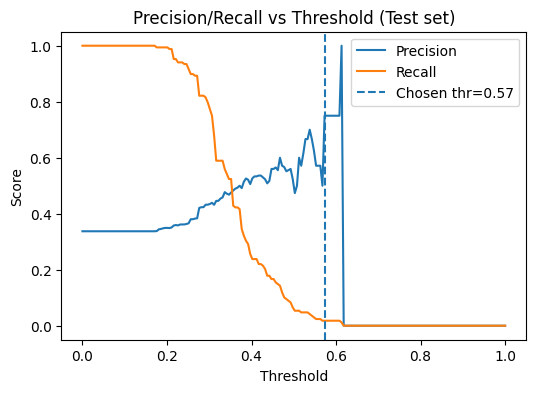

Saved top 50 to output/xgb_1_predictions_2024.csv


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score

INPUT_CSV = "output/processed_dataset.csv"
INPUT_2024_CSV = "output/processed_2024_dataset.csv"
OUTPUT_CSV = "output/xgb_1_predictions_2024.csv"

TARGET_PRECISION = 0.90
TARGET_F1 = 0.70
MIN_POS_FRAC_TRAIN = 0.002
RANDOM_STATE = 42

def eval_at_threshold(y_true, scores, thr):
    y_pred = (scores >= thr).astype(int)
    p = precision_score(y_true, y_pred, zero_division=0)
    r = recall_score(y_true, y_pred, zero_division=0)
    f = f1_score(y_true, y_pred, zero_division=0)
    k = int(y_pred.sum())
    return p, r, f, k

def pick_train_threshold(y_train, s_train):
    n = len(y_train)
    min_pos = int(np.ceil(MIN_POS_FRAC_TRAIN * n)) if MIN_POS_FRAC_TRAIN > 0 else 0
    uniq = np.unique(s_train)
    grid = np.linspace(0.01, 0.99, 199)
    qu = np.unique(np.quantile(s_train, q=np.linspace(0.50, 0.999, 200)))
    candidates = np.unique(np.clip(np.concatenate([uniq, grid, qu]), 1e-6, 1 - 1e-6))
    feasible, stats = [], []
    for t in candidates:
        p, r, f, k = eval_at_threshold(y_train, s_train, t)
        stats.append((t, p, r, f, k))
        if k >= min_pos and p >= TARGET_PRECISION and f >= TARGET_F1:
            feasible.append((t, p, r, f, k))
    if feasible:
        feasible.sort(key=lambda x: (x[2], x[0]), reverse=True)
        return float(feasible[0][0])
    stats.sort(key=lambda x: (x[1], x[3], x[0]), reverse=True)
    return float(stats[0][0])

print("Loading datasets...")
df = pd.read_csv(INPUT_CSV)
df_2024 = pd.read_csv(INPUT_2024_CSV)

train_df = df[df["year"].between(2005, 2022)].copy()
test_df  = df[df["year"] == 2023].copy()

feature_cols = [c for c in train_df.columns if c not in ["ticker", "year", "beat_index"]]
X_train = train_df[feature_cols].values
y_train = train_df["beat_index"].astype(int).values
X_test  = test_df[feature_cols].values
y_test  = test_df["beat_index"].astype(int).values

neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
scale_pos_weight = float(neg) / max(float(pos), 1.0)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

print("Training XGBoost model...")
model = XGBClassifier(
    n_estimators=700,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.85,
    colsample_bytree=0.85,
    reg_lambda=2.0,
    min_child_weight=1.0,
    scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    tree_method="hist",
    eval_metric="aucpr",
)
model.fit(X_train_s, y_train)

cal = CalibratedClassifierCV(model, cv=5, method="isotonic")
cal.fit(X_train_s, y_train)
proba_train = cal.predict_proba(X_train_s)[:, 1]
proba_test  = cal.predict_proba(X_test_s)[:, 1]
scorer_for_2024 = cal

print(f"PR-AUC (TRAIN): {average_precision_score(y_train, proba_train):.4f}")

thr = pick_train_threshold(y_train, proba_train)
p_tr, r_tr, f_tr, k_tr = eval_at_threshold(y_train, proba_train, thr)
p_te, r_te, f_te, k_te = eval_at_threshold(y_test,  proba_test,  thr)

print(f"Threshold: {thr:.6f}")
print(f"TRAIN -> Precision {p_tr:.3f}, Recall {r_tr:.3f}, F1 {f_tr:.3f}, Pos {k_tr}")
print(f"TEST  -> Precision {p_te:.3f}, Recall {r_te:.3f}, F1 {f_te:.3f}, Pos {k_te}")

# ---- Precision/Recall vs threshold (Test set) ----
thresholds = np.linspace(0.0, 1.0, 200)
precisions, recalls = [], []
for t in thresholds:
    p, r, _, _ = eval_at_threshold(y_test, proba_test, t)
    precisions.append(p)
    recalls.append(r)

plt.figure(figsize=(6, 4))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.axvline(thr, linestyle="--", label=f"Chosen thr={thr:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision/Recall vs Threshold (Test set)")
plt.legend()
plt.show()

# ---- Score and save 2024 ----
X_2024 = df_2024[feature_cols].values
X_2024_s = scaler.transform(X_2024)
proba_2024 = scorer_for_2024.predict_proba(X_2024_s)[:, 1]
pred_2024 = pd.DataFrame({
    "ticker": df_2024["ticker"],
    "year": df_2024["year"],
    "winner_probability": proba_2024
})
top_50 = pred_2024.sort_values(by="winner_probability", ascending=False).head(50)
os.makedirs(os.path.dirname(OUTPUT_CSV), exist_ok=True)
top_50.to_csv(OUTPUT_CSV, index=False)
print(f"Saved top 50 to {OUTPUT_CSV}")


In [2]:
import pandas as pd

OUTPUT_CSV = "output/xgb_1_predictions_2024.csv"
df_top = pd.read_csv(OUTPUT_CSV)
df_top.head(50)


,ticker,year,winner_probability
0,CEG,2024,0.636454
1,SMCI,2024,0.632732
2,NVDA,2024,0.623596
3,TRGP,2024,0.592126
4,PANW,2024,0.583349
5,HWM,2024,0.551069
6,GDDY,2024,0.533865
7,COST,2024,0.532398
8,ZBRA,2024,0.529819
9,ACGL,2024,0.526648
